In [1]:
import sys

# adding Folder_2 to the system path
#sys.path.insert(0, '/Users/lisadang/Desktop/Github/SPCA')

# path to astro_models
sys.path.insert(0, '/Users/alexandrarochon/Programming/LHS1140-Eureka/myAnalysis')
import astro_models
import numpy as np
import matplotlib.pyplot as plt
import pickle, os
import batman
import emcee
import astropy
from astropy.time import Time
import h5py
import corner
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from multiprocessing import Pool
import matplotlib.ticker as mticker
from mc3.stats import time_avg
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy.visualization import quantity_support
import matplotlib.patches as patches
from scipy.optimize import curve_fit


In [2]:
eclipse = ['2']
aperture = ['5']
#aperture = ['4', '7', '12']
segments = ['0000', '0001', '0002', '0003', '0004']

# Initialize dictionaries to hold arrays for each aperture
time_arr = {a: [] for a in aperture}
aplev_arr = {a: [] for a in aperture}
aperr_arr = {a: [] for a in aperture}
centroid_x_arr = {a: [] for a in aperture}
centroid_y_arr = {a: [] for a in aperture}

for a in aperture:
    for seg in segments:
        if eclipse[0] == '1':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+eclipse[0]+'/LHS1140c-S3_ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif eclipse[0] == '2':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+eclipse[0]+'/Stage3/S3_2024-07-22_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif eclipse[0] == '3':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+eclipse[0]+'/Stage3/S3_2024-08-05_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        with h5py.File(path, 'r') as file:     # open the file
            time_arr[a] = np.append(time_arr[a], np.array(file['time']))
            aplev_arr[a] = np.append(aplev_arr[a], np.array(file['aplev']))
            aperr_arr[a] = np.append(aperr_arr[a], np.array(file['aperr']))
            centroid_x_arr[a] = np.append(centroid_x_arr[a], np.array(file['centroid_x']))
            centroid_y_arr[a] = np.append(centroid_y_arr[a], np.array(file['centroid_y']))

    time_arr[a] = np.array(time_arr[a])
    aplev_arr[a] = np.array(aplev_arr[a])
    aperr_arr[a] = np.array(aperr_arr[a])
    centroid_x_arr[a] = np.array(centroid_x_arr[a])
    centroid_y_arr[a] = np.array(centroid_y_arr[a])
    
print(time_arr['5'])

[60498.67479143 60498.67491971 60498.67504799 ... 60498.83629769
 60498.83642597 60498.83655426]


Text(0, 0.5, 'Normalized Flux')

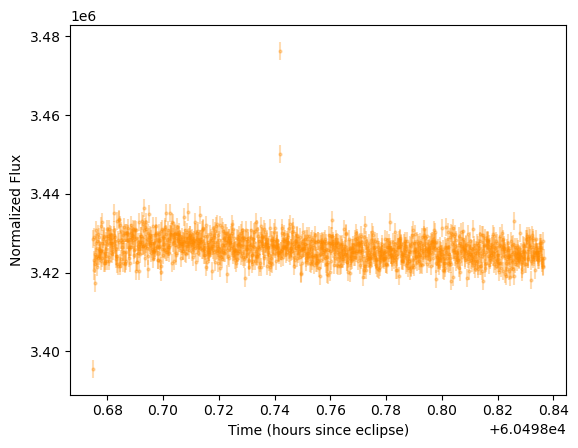

In [3]:
plt.errorbar(time_arr['5'], aplev_arr['5'], yerr=aperr_arr['5'], color='darkorange',markersize=2, alpha=0.3, fmt='o')
plt.xlabel('Time (hours since eclipse)')
plt.ylabel('Normalized Flux')

In [233]:
# remove the first 2 points, rename arrays, normalize and set t_s = 0
ndiscard = 2
time = time_arr['5'][ndiscard:]
aplev = aplev_arr['5'][ndiscard:]
aperr = aperr_arr['5'][ndiscard:]
centroid_x = centroid_x_arr['5'][ndiscard:]
centroid_y = centroid_y_arr['5'][ndiscard:]

# set up parameters and set t_s = 0
eclipse = Time('2024-07-07 18:34', format = 'iso', scale = 'tdb')
eclipse = eclipse.mjd
eclipse = (eclipse-time[0])*24
e_dur = 1.13 # hours
e_dur_days = e_dur / 24

# set up parameters for the MCMC
model_type = 'exp+polynomial_2nd_order_centroid' # 'exp+linear' or 'exp' or 'polynomial' OR 'exp_1st_order_centroid' or 'exp+polynomial' or 'exp_2nd_order_centroid'
chosen_model = model_type
t_s = (60498.77361111111-time[0])*(24)
fp = 0.000230
p0_astro = np.array([t_s, fp]) 
time = (time - time[0])*(24)

In [234]:
# first guess from scipy curve_fit on the data
p0_detec = []
centroid = False
if 'exp' in model_type:
    p0_detec += [0.9442588023676416, 0.00023172786914537203, 0.056190963345282764]
if 'double_exp' in model_type:
    p0_detec = [0.9991526651706766, -0.00011774395530832629, 0.00381323262988453, 1.5879568358981915]
if 'linear' in model_type:
    p0_detec += [-0.00021872009640224572, 1.0004497232626075]
if 'polynomial' in model_type:
    p0_detec += [9.05030776e-05, -5.54250578e-04,  6.96441578e-04,  1.00011736e+00]
if '2nd_order_centroid' in model_type:
    p0_detec = np.append([0.5, 0.1, 0.1, -0.1, 0.1, 0.1], p0_detec)
    centroid = True

aperr = aperr / np.mean(aplev)
aplev = aplev / np.mean(aplev)

In [235]:
def transit_model(time, t_s, fp):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 58388.7939*24
    params.per = 3.777940*24              #orbital period in hours
    params.rp = 0.0539                    #planet radius (in units of stellar radii) # check that this is ratio of radii -> 0.0539 is charles value
    params.a = 26.57                      #semi-major axis (in units of stellar radii)
    params.inc = 89.8                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.16, 0.22]               #limb darkening coefficients, values from cadieux 2024b
    params.fp = fp                        #planet to star flux ratio
    params.t_secondary = t_s

    m = batman.TransitModel(params, time, transittype="secondary")
    flux = m.light_curve(params)
    return flux

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def linear_slope(time, m, b):
    return m*time + b

def poly_3rd_degree(t, a, b, c, d):
    return a * t**3 + b * t**2 + c * t + d

def double_exponential(time, c1, c2, c3, c4):
    return c1 * np.exp(-c2 * time) + c3 * np.exp(-c4 * time)

def detec_model_poly(xdata, ydata, c1, c2, c3, c4, c5, c6):
    x, y = xdata, ydata
    pos = np.vstack((np.ones_like(x),
                     x   ,      y,
                     x**2, x   *y,      y**2))
    detec = np.array([c1, c2, c3, c4, c5, c6])
    return np.dot(detec[np.newaxis,:], pos).reshape(-1)

def detec_model(time, centroid_x, centroid_y, theta, model_type):
    detec = []
    centroid = False

    if '2nd_order_centroid' in model_type:
        detec_centroid = detec_model_poly(centroid_x, centroid_y, theta[2], theta[3], theta[4], theta[5], theta[6], theta[7])
        theta = np.delete(theta, np.s_[2:8])
        model_type = model_type.replace('_2nd_order_centroid', '')  # Remove for processing
        centroid = True

    if model_type == 'exp+linear':
        t_s, fp, c1, c2, c3, c4, c5, sigF = theta
        detec = exponential_func(time, c1, c2, c3)*linear_slope(time, c4, c5)
    elif model_type == 'exp':
        t_s, fp, c1, c2, c3, sigF = theta
        detec = exponential_func(time, c1, c2, c3)
    elif model_type == 'linear':
        t_s, fp, c1, c2, sigF = theta
        detec = linear_slope(time, c1, c2)
    elif model_type == 'polynomial':
        t_s, fp, c1, c2, c3, c4, sigF = theta
        detec = poly_3rd_degree(time, c1, c2, c3, c4)
    elif model_type == 'exp+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF = theta
        detec = exponential_func(time, c1, c2, c3)*poly_3rd_degree(time, c4, c5, c6, c7)
    elif model_type == 'linear+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF = theta
        detec = linear_slope(time, c1, c2)*poly_3rd_degree(time, c3, c4, c5, c6)
    elif model_type == 'double_exp':
        t_s, fp, c1, c2, c3, c4, sigF = theta
        detec = double_exponential(time, c1, c2, c3, c4)

    if centroid:
        detec = detec * detec_centroid
    return detec

def signal(time, centroid_x, centroid_y, theta, model_type):
    t_s = theta[0]
    fp = theta[1]
    astro = transit_model(time, t_s, fp)
    detec = detec_model(time, centroid_x, centroid_y, theta, model_type)
    return astro*detec


In [236]:
def log_likelihood(theta, time, flux, centroid_x, centroid_y, model_type):
    model = signal(time, centroid_x, centroid_y, theta, model_type)
    sigF = theta[-1]
    sigma2 = sigF**2
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta, model_type):
    prior = 0.
    t_s = theta[0]
    fp = theta[1]
    sigF = theta[-1]
    if (0 < fp < 1 and (eclipse-(e_dur_days/2)) < t_s < (eclipse+(e_dur_days/2)) and sigF > 0. ): 
        return 0.0 + prior
    return np.inf

def log_prob(theta, time, flux, centroid_x, centroid_y, model_type):
    lp = log_prior(theta, model_type)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux, centroid_x, centroid_y, model_type)

In [237]:
p0 = np.concatenate((p0_astro, p0_detec, [0.001]))
nsteps, nwalkers, ndim = 10000, 70, len(p0)

# lower the initial position scatter
pos = p0 + 1e-5 * np.random.randn(nwalkers, ndim)

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time, aplev, centroid_x, centroid_y)) 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time, aplev, centroid_x, centroid_y, model_type))

pos2, prob, state = sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 10000/10000 [03:06<00:00, 53.52it/s]


In [238]:
nBurnInSteps2 = 1000
lnprobchain = sampler.get_log_prob(discard=nBurnInSteps2).swapaxes(0,1)
chain = sampler.get_chain(discard=nBurnInSteps2).swapaxes(0,1)

# Save the chains
ecl = '2'
savepath = 'MCMC_results/ecl'+ecl+'_'+model_type+'_test_'
pathchain = savepath + 'samplerchain_10000.npy'
pathlnlchain = savepath + 'samplerlnlchain_10000.npy'
pathposit = savepath + 'samplerposi_10000.npy'
pathlnpro = savepath + 'samplerlnpr_10000.npy'
np.save(pathchain, chain)
np.save(pathlnlchain, lnprobchain)
np.save(pathposit, pos2)
np.save(pathlnpro, prob)

In [239]:
samples = chain.reshape((-1, ndim))

MCMC_Results = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))))

maxk, maxiter = np.unravel_index((lnprobchain).argmax(), (lnprobchain).shape)
p0_mcmc = chain[maxk, maxiter,:]
for i in range(len(p0_mcmc)):
    MCMC_Results[i] = (p0_mcmc[i], MCMC_Results[i][1], MCMC_Results[i][2])

p0_labels = ['t_s','fp', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'c_10', 'c_11', 'c_12', 'c_13', 'sigF']
p0_labels[ndim-1] ='sigF'

out = "MCMC result:\n\n"
for i in range(len(p0_mcmc)):
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format(p0_labels[i],MCMC_Results[i][0], MCMC_Results[i][1], MCMC_Results[i][2])
print(out, flush=True)
p0_centroid = p0_mcmc

MCMC result:

     t_s = 2.3564893352874807  +0.018998479455017314  -0.013268623732548779
      fp = 8.112307673042153e-05  +0.007913823623859246  -0.0001086913699568909
     c_1 = -0.37988156103280685  +0.5932294104138213  -0.643592561961524
     c_2 = 0.04407380425566681  +0.17267282677042028  -0.03934266856910396
     c_3 = 0.081802242052233  +0.15297885324130078  -0.19250614737131505
     c_4 = 0.1594637288854358  +0.1315678175404195  -0.07631009678603254
     c_5 = -0.3209859249578801  +0.15388806885828077  -0.26584643599424673
     c_6 = 0.1607260329033333  +0.1211737310692355  -0.09272418214910674
     c_7 = 0.7016182189447316  +0.03353171585675552  -0.08309678333070813
     c_8 = 0.06100892067088581  +0.017214001641875656  -0.10924876258144518
     c_9 = -0.28224025294696764  +0.2609295936317053  -0.0303263197922769
    c_10 = 0.0008129706861629429  +0.0015665444272465942  -0.0005108761871615592
    c_11 = 0.0048612641585058704  +0.0022393563796326774  -0.01972942264548972
    

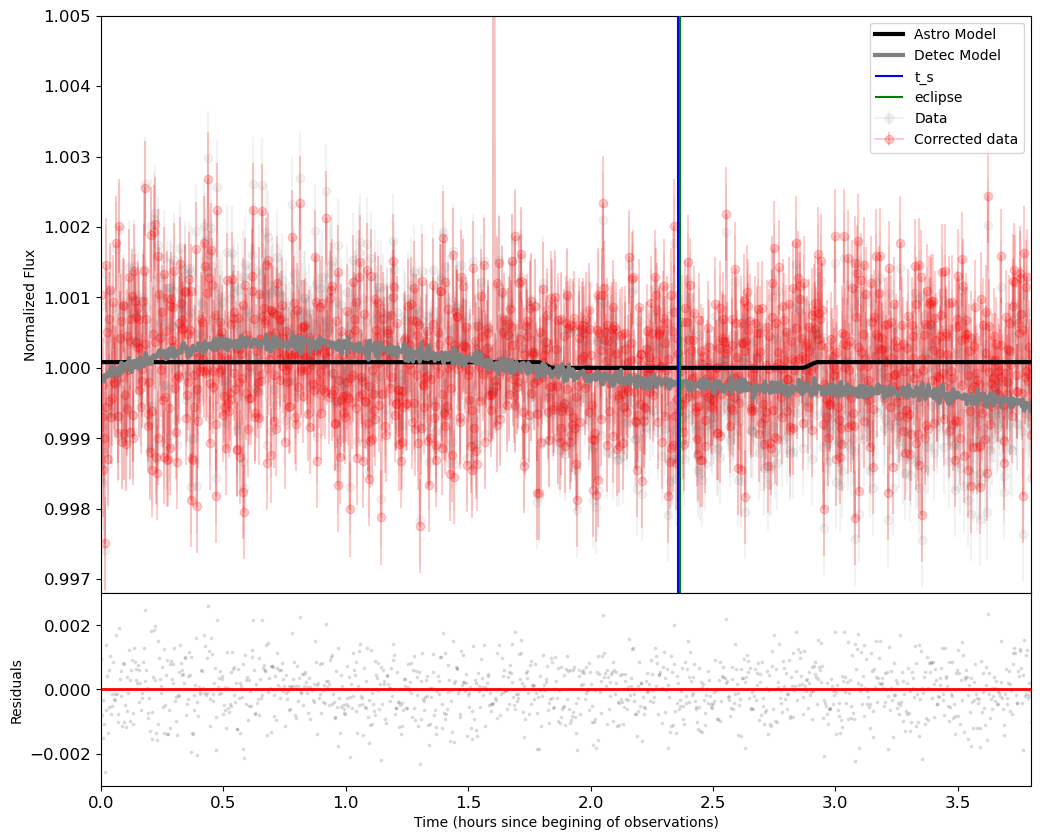

In [240]:
detec = []
model_type = chosen_model

# this can be simplified with p0_mcmc[0] and 1 assigned ts and fp and everything else passed into detec_model
if '2nd_order_centroid' in model_type:
    p0_mcmc = p0_centroid
    detec_centroid = detec_model_poly(centroid_x, centroid_y, p0_mcmc[2], p0_mcmc[3], p0_mcmc[4], p0_mcmc[5], p0_mcmc[6], p0_mcmc[7])
    p0_mcmc = np.delete(p0_mcmc, np.s_[2:8])
    model_type = model_type.replace('_2nd_order_centroid', '')  # Remove for processing
    centroid = True
if model_type == 'exp+linear':
    t_s, fp, c1, c2, c3, c4, c5, sigF = p0_mcmc
    detec = detec_model(time, centroid_x, centroid_y, [t_s, fp, c1, c2, c3, c4, c5, sigF], model_type)
elif model_type == 'exp':
    t_s, fp, c1, c2, c3, sigF = p0_mcmc
    detec = detec_model(time, centroid_x, centroid_y, [t_s, fp, c1, c2, c3, sigF], model_type)
elif model_type == 'linear':
    t_s, fp, c1, c2, sigF = p0_mcmc
    detec = detec_model(time, centroid_x, centroid_y,[t_s, fp, c1, c2, sigF], model_type)
elif model_type == 'polynomial':
    t_s, fp, c1, c2, c3, c4, sigF = p0_mcmc
    detec = detec_model(time, centroid_x, centroid_y, [t_s, fp, c1, c2, c3, c4, sigF], model_type)
elif model_type == 'exp+polynomial':
    t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF = p0_mcmc
    detec = detec_model(time, centroid_x, centroid_y, [t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF], model_type)
elif model_type == 'double_exp':
    t_s, fp, c1, c2, c3, c4, sigF = p0_mcmc
    detec = detec_model(time, centroid_x, centroid_y, [t_s, fp, c1, c2, c3, c4, sigF], model_type)
elif model_type == 'linear+polynomial':
    t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
    detec = detec_model(time, centroid_x, centroid_y, [t_s, fp, c1, c2, c3, c4, c5, c6, sigF], model_type)
astro = transit_model(time, t_s, fp)


if centroid:
    detec = detec * detec_centroid

fig, ax = plt.subplots(2, 1, figsize=(12, 10),  gridspec_kw={'height_ratios': [3, 1]})
ax[0].errorbar(time, aplev, yerr =aperr, label='Data', color='grey', alpha=0.1, marker='o', zorder=1)
ax[0].errorbar(time, aplev/detec, yerr =aperr, label='Corrected data', color='red', alpha=0.2, marker='o', zorder=1)
ax[0].plot(time, astro, label='Astro Model',color = 'black', zorder=2, linewidth=3)
ax[0].plot(time, detec, label='Detec Model', color = 'grey', zorder=2, linewidth=3)
ax[0].vlines(t_s, 0.994, 1.008, color='blue', label='t_s', zorder=3)
ax[0].vlines(eclipse, 0.994, 1.008, color='green', label='eclipse', zorder=3)
ax[0].set_ylim(0.9968, 1.005)
ax[1].set_ylim(-0.003, 0.003)
ax[0].set_xlim(0, 3.8)
ax[1].set_xlim(0, 3.8)
ax[0].legend()
residuals = (aplev/detec)-astro
ax[1].scatter(time,residuals, label='Residuals', color='black', alpha=0.1, marker='o', s=3)
ax[1].axhline(y=0, color='r', linewidth = 2)
ax[0].set_ylabel('Normalized Flux')
ax[1].set_ylabel('Residuals')
#hide y axis
ax[0].set_xticks([])  # Remove x-axis ticks
ax[0].set_xlabel('')  # Remove x-axis label

# no h space
plt.subplots_adjust(hspace=0.0)
plt.xlabel('Time (hours since begining of observations)')
plt.savefig('MCMC_results/ecl'+ecl+'_'+chosen_model+'_test.png', bbox_inches='tight')
plt.show()

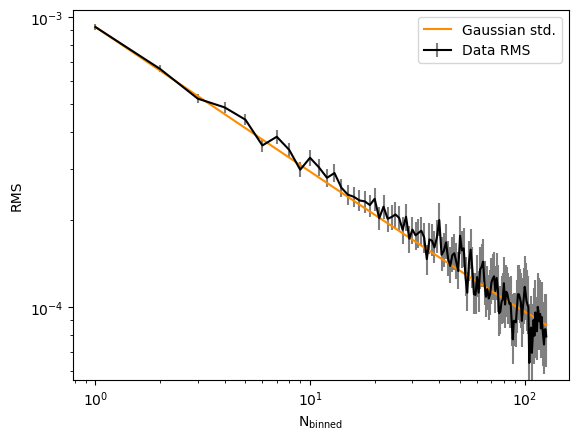

In [241]:
def plot_rednoise(residuals, minbins, occDuration = None, showPlot=True, fname=None, fontsize=10):
    
    maxbins = int(np.rint(residuals.size/minbins))
    
    try:
        rms, rmslo, rmshi, stderr, binsz = time_avg(residuals, maxbins)
    except:
        rms = []
        for i in range(minbins,len(residuals)):
            rms.append(helpers.binnedNoise(np.arange(len(residuals)),residuals,i))
        rms = np.array(rms)[::-1]

        binsz = len(residuals)/np.arange(minbins,len(residuals))[::-1]

        #In case there is a NaN or something while binning
        binsz = binsz[np.isfinite(rms)]
        rms = rms[np.isfinite(rms)]
        rmslo = np.zeros_like(rms)
        rmshi = rmslo
        stderr = np.std(residuals)/np.sqrt(binsz)
    
    plt.clf()
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.errorbar(binsz, rms, yerr=[rmslo, rmshi], fmt="k-", ecolor='0.5', capsize=0, label="Data RMS")
    ax.plot(binsz, stderr, c='darkorange', label="Gaussian std.")
    ylim = ax.get_ylim()
    # ax.plot([ingrDuration,ingrDuration],ylim, color='black', ls='--', alpha=0.6)
    if occDuration is not None:
        ax.plot([occDuration,occDuration],ylim, color='black', ls='-.', alpha=0.6)
    ax.set_ylim(ylim)
    
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    
    plt.xlabel(r'N$_{\rm binned}$', fontsize=fontsize)
    plt.ylabel('RMS', fontsize=fontsize)
    plt.legend(loc='best', fontsize=fontsize)
    if fname is not None:
        plt.savefig(fname)

    if showPlot:
        plt.show()
    
    plt.close()

plot_rednoise(residuals, 10, fname='MCMC_results/ecl'+ecl+'_'+chosen_model+'_test_rednoise.png')

In [242]:
# calculate RMS
rms = np.std(residuals)
print('RMS = ', rms*1e6, 'ppm')  

# using convolution dont think this is right?
conv = np.convolve(aplev, residuals, mode='full')
rms2 = np.std(conv)
print('RMS2 = ', rms2)

# calculate chi2
chi2 = np.sum((residuals)**2 / (aperr)**2)
def chi_squared(aplev, astro, detec, p0_mcmc):    
    sigF = p0_mcmc[-1]
    sigma2 = sigF**2
    return np.sum((aplev - astro*detec) ** 2 / sigma2)

chi = chi_squared(aplev, astro, detec, p0_mcmc)
print('chi2 = ', chi)

# calculate BIC
def BIC(n_dat, n_par, lnL):
    return n_par*np.log(n_dat) - 2*lnL  

# lnL is the likelihood value of best fit model, formula that depends on chi2, recheck
bic = BIC(len(time), len(p0_mcmc), lnprobchain.max())
print('BIC:', bic)

# write to a text file with the same naming convention as the saved chains
textfile = savepath + 'results.txt'
with open(textfile, 'w') as f:
    f.write(out)
    f.write('RMS = '+str(rms*1e6)+' ppm\n')
    f.write('chi2 = '+str(chi)+'\n')
    f.write('BIC = '+str(bic)+'\n')
    f.write('RMS2 = '+str(rms2)+'\n')
    f.close()

RMS =  923.0577339037278 ppm
RMS2 =  0.009321258719188801
chi2 =  1267.3406458830884
BIC: -16277.975248843857


In [243]:
# bin the data
def binValues(values, binAxisValues, nbin, assumeWhiteNoise=True):
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))
    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr

# retrieve proper errorbars on aplev
def binFluxError(values, error, binAxisValues, nbin, assumeWhiteNoise=True):
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binCounts = np.array([np.sum(digitized == i) for i in range(1, nbin)])

    binnedErr = np.array([np.mean(error[digitized == i]) for i in range(1, nbin)])/np.sqrt(binCounts)

    return binned, binnedErr

nbin = 100
bins_time, binErr_t = binValues(time, time, nbin)
bins_aplev, binErr_aplev = binFluxError(aplev, aperr, time, nbin)
detec_bins, detecErr_bins = binValues(detec, time, nbin)

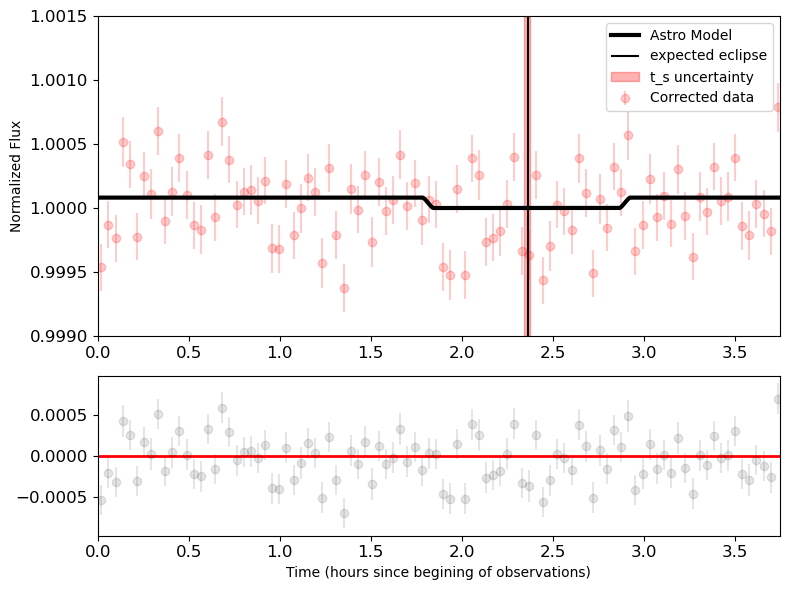

In [244]:
astro_bins = transit_model(bins_time, t_s, fp)
fig, ax = plt.subplots(2, 1, figsize=(8, 6),  gridspec_kw={'height_ratios': [2, 1]})
ax[0].errorbar(bins_time, bins_aplev/detec_bins, yerr=binErr_aplev, label='Corrected data', color='red', linestyle='none', alpha=0.2, marker='o', zorder=1)
ax[0].plot(time, transit_model(time, t_s, fp), label='Astro Model',color = 'black', zorder=2, linewidth=3)
ax[0].vlines(eclipse, 0.994, 1.008, color='black', label='expected eclipse', zorder=3)
ax[0].axvspan(t_s-MCMC_Results[0][2], t_s+MCMC_Results[0][1], color='red', alpha=0.3, label = 't_s uncertainty')
ax[0].set_ylim(0.999, 1.0015)
ax[0].set_xlim(0,3.75)
ax[1].set_xlim(0,3.75)
ax[0].legend()
## should residuals be binned instead of re-calculated
residuals = (bins_aplev/detec_bins)-astro_bins
ax[1].errorbar(bins_time,residuals,yerr=binErr_aplev,  label='Residuals', color='black', alpha=0.1, marker='o', linestyle='none')
ax[1].axhline(y=0, color='r', linewidth = 2)
fig.subplots_adjust(hspace=0)
plt.xlabel('Time (hours since begining of observations)')
ax[0].set_ylabel('Normalized Flux') 
plt.tight_layout()  
plt.savefig('MCMC_results/ecl'+ecl+'_'+chosen_model+'_test_binned.png')


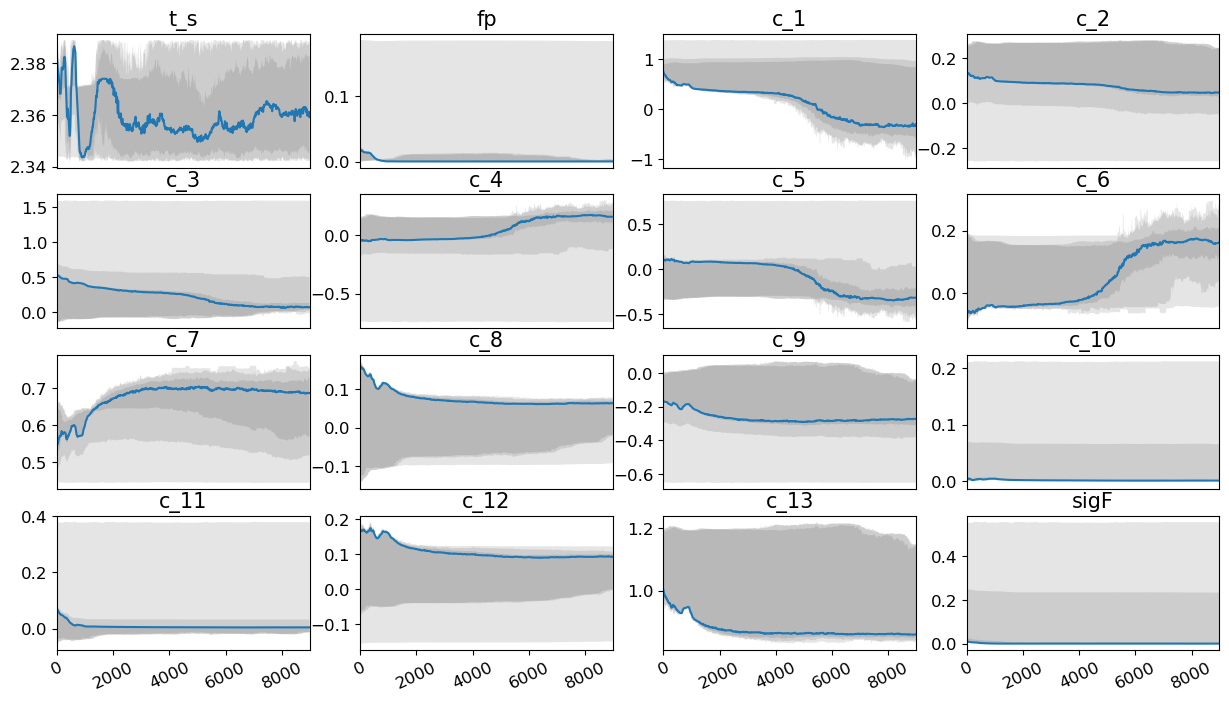

In [245]:
def walk_style(chain, labels, interv=10, fname=None, showPlot=False, fontsize=15):
    nwalk = chain.shape[0]
    ndim = chain.shape[-1]

    # get first index
    beg   = 0
    end   = len(chain[0,:,0])
    step  = np.arange(beg,end)
    step  = step[::interv]

    # number of columns and rows of subplots
    ncols = 4
    nrows = int(np.ceil(ndim/ncols))
    sizey = 2*nrows

    # plotting
    plt.figure(figsize = (15, 2*nrows))
    for ind in range(ndim):
        plt.subplot(nrows, ncols, ind+1)
        sig1 = (0.6827)/2.*100
        sig2 = (0.9545)/2.*100
        sig3 = (0.9973)/2.*100
        percentiles = [50-sig3, 50-sig2, 50-sig1, 50, 50+sig1, 50+sig2, 50+sig3]
        neg3sig, neg2sig, neg1sig, mu_param, pos1sig, pos2sig, pos3sig = np.percentile(chain[:,:,ind][:,beg:end:interv],
                                                                                       percentiles, axis=0)
        plt.plot(step, mu_param)
        plt.fill_between(step, pos3sig, neg3sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos2sig, neg2sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos1sig, neg1sig, facecolor='k', alpha = 0.1)
        plt.title(labels[ind], fontsize=fontsize)
        plt.xlim(np.min(step), np.max(step))
        if ind < (ndim - ncols):
            plt.xticks([])
        else:
            plt.xticks(rotation=25)

        y_formatter = ScalarFormatter(useOffset=False)
        plt.gca().yaxis.set_major_formatter(y_formatter)
        plt.gca().xaxis.set_tick_params(labelsize=fontsize*0.8)
        plt.gca().yaxis.set_tick_params(labelsize=fontsize*0.8)

    if fname != None:
        plt.savefig(fname, bbox_inches='tight')

    if showPlot:
        plt.show()

    #plt.close()
    return

walk_style(chain, p0_labels, interv=10, fname='MCMC_results/ecl'+ecl+'_'+chosen_model+'_test_walkers.png', showPlot=True, fontsize=15)

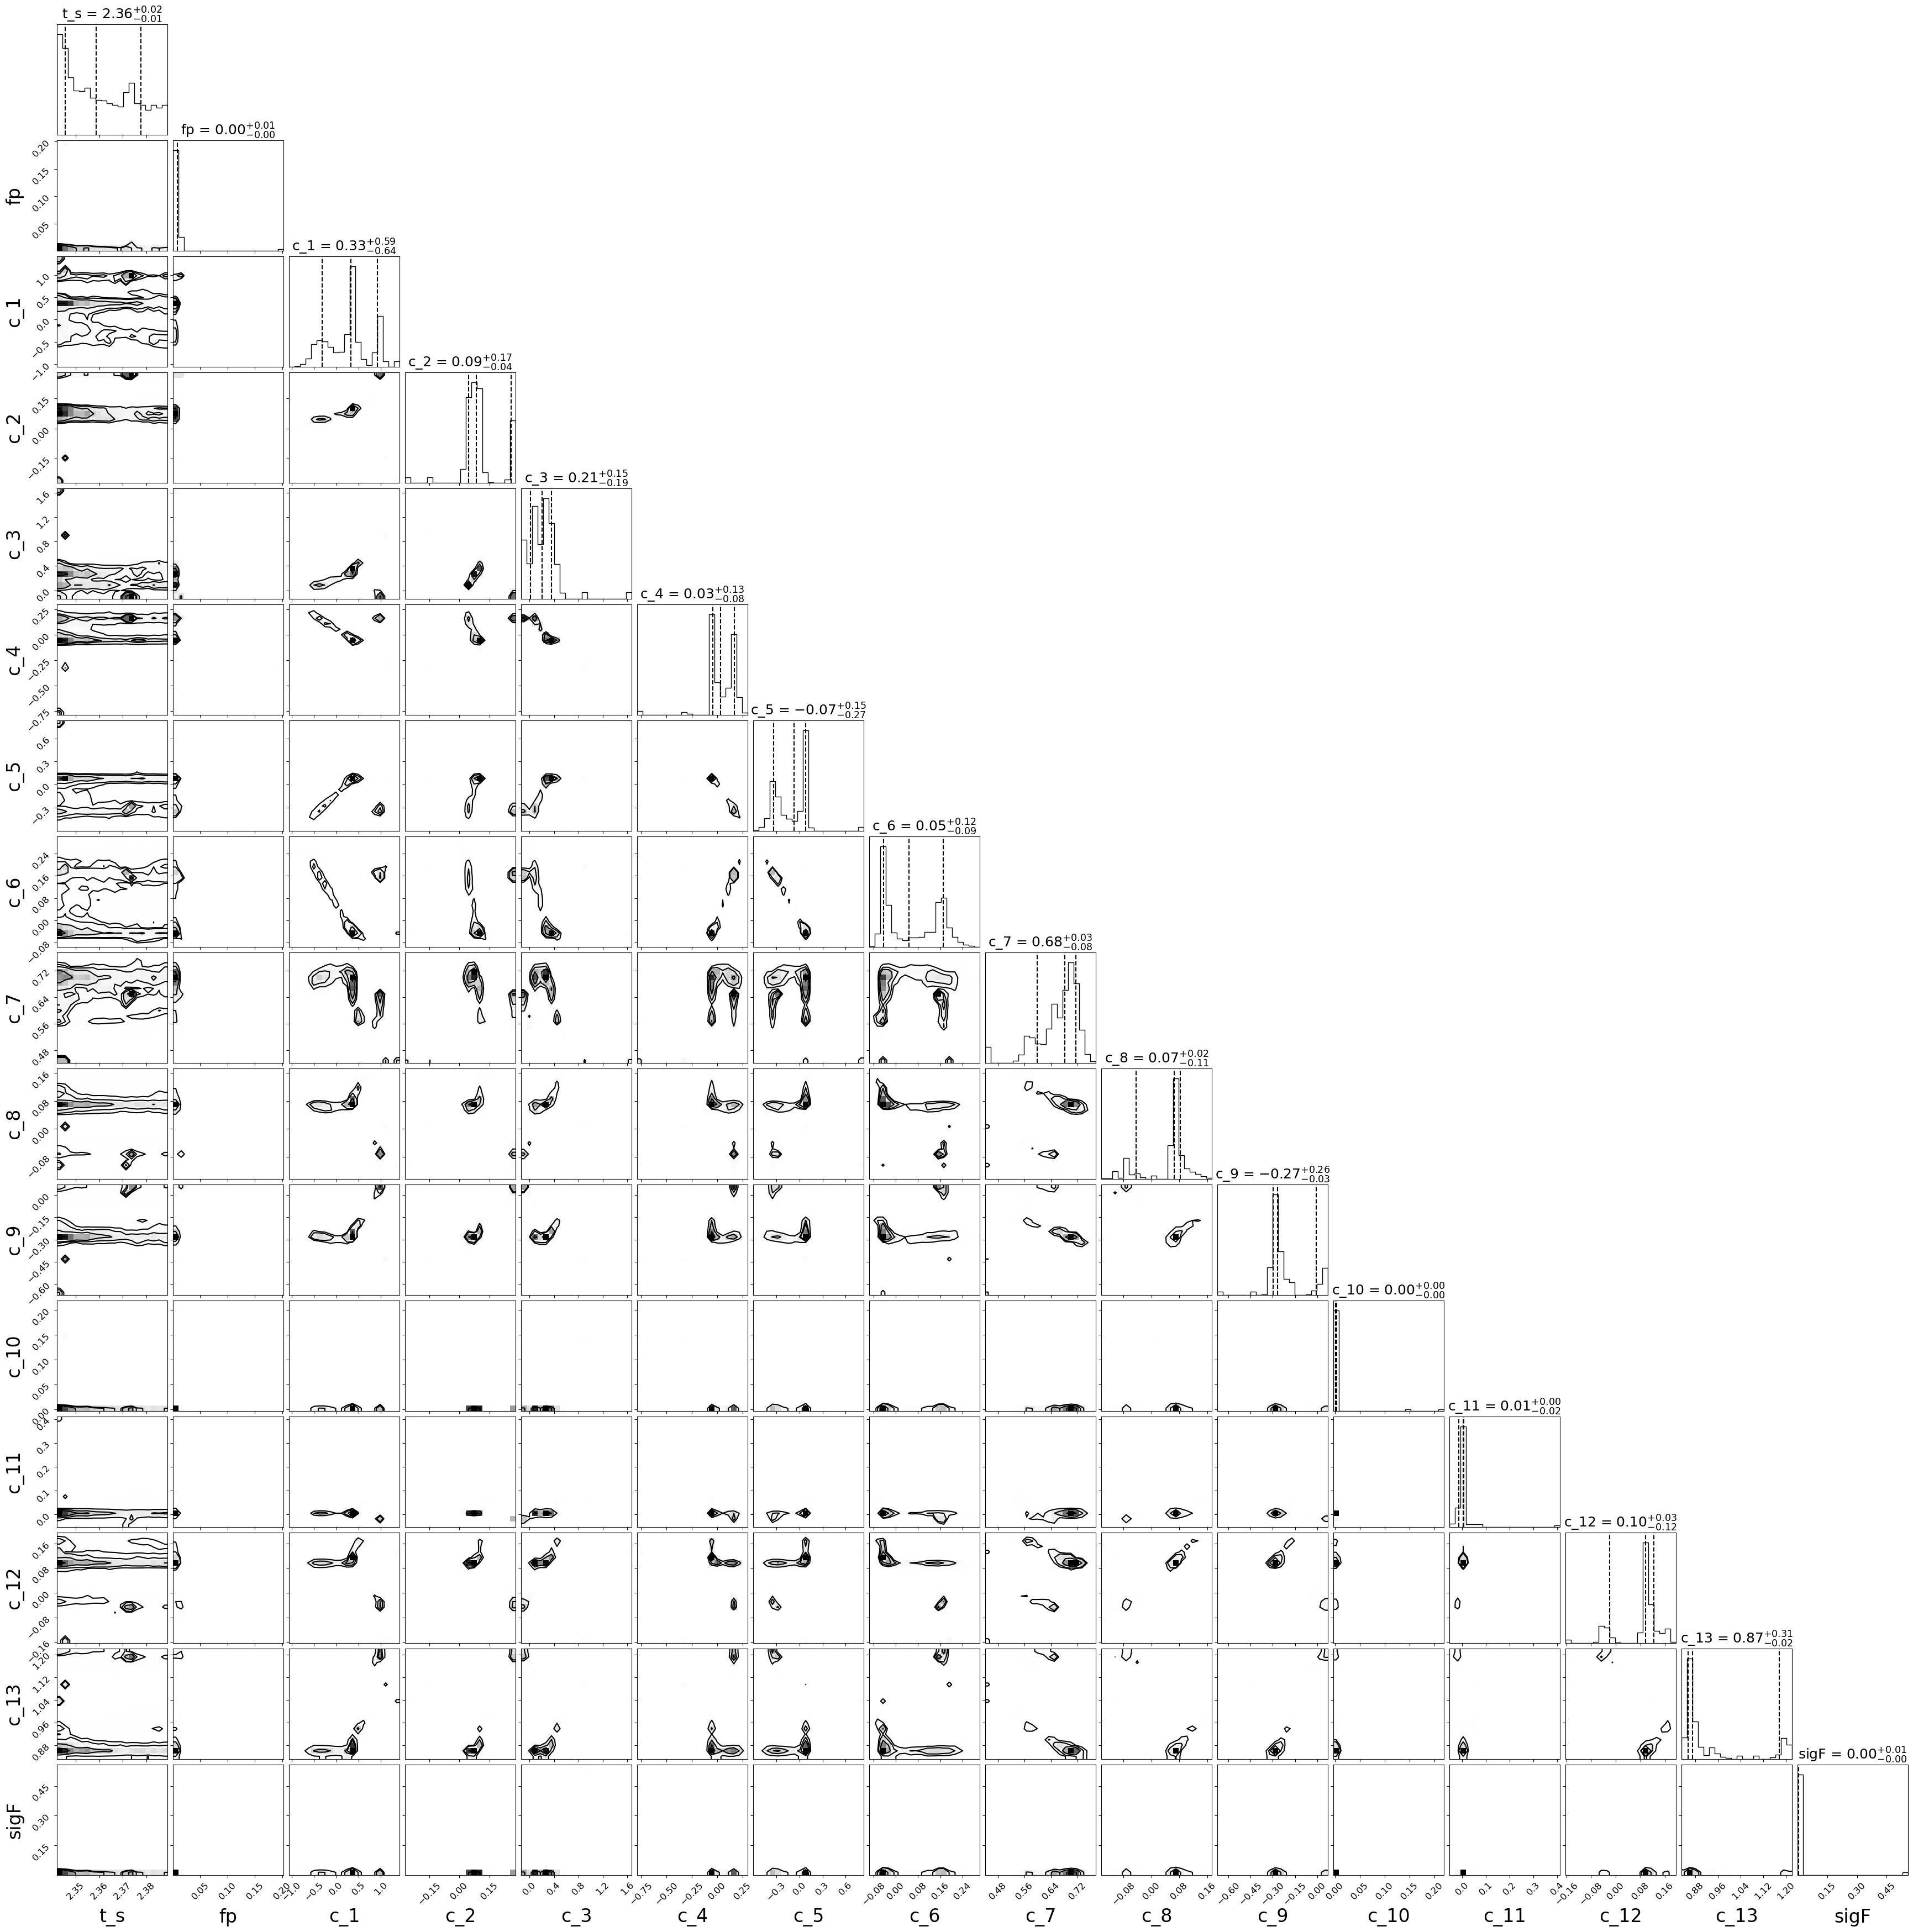

In [246]:
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

samples = chain.reshape((-1, ndim))
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], labels = p0_labels, show_titles=True,
                        plot_datapoints=False, label_kwargs={"fontsize": 24}, title_kwargs={"fontsize": 18}, quiet=False)

fig.savefig('MCMC_results/ecl'+ecl+'_'+chosen_model+'_test_corners.png')
#plt.close()